In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Any results you write to the current directory are saved as output.

In [4]:
df = pd.read_csv("/workspace/train.csv")
df["image_id"] = df["ImageId_ClassId"].apply(lambda val: val.split("_")[0])
df["class_id"] = df["ImageId_ClassId"].apply(lambda val: val.split("_")[1])
df = df.rename(columns={"EncodedPixels": "encoded_pixels"})
df = df[["image_id", "class_id", "encoded_pixels"]]

# compute test/train split
vals = np.random.uniform(0, 1, len(df))
train_idx = vals < 0.8
val_idx = vals >= 0.8

df["train"] = False
df["train"][train_idx] = True

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,image_id,class_id,encoded_pixels,train
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True
1,0002cc93b.jpg,2,NaN,True
2,0002cc93b.jpg,3,NaN,True
3,0002cc93b.jpg,4,NaN,True
4,00031f466.jpg,1,NaN,True


In [5]:
with_pixels = df.dropna()
with_pixels.head()

,image_id,class_id,encoded_pixels,train
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,True
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,True
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,True
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,True


In [6]:
filename, class_id = with_pixels.iloc[0].image_id, with_pixels.iloc[0].class_id
print(filename, class_id)

0002cc93b.jpg 1


In [7]:
def compute_mask(row, shape):
    width, height = shape
    
    mask = np.zeros(width * height, dtype=np.uint8)
    pixels = np.array(list(map(int, row.encoded_pixels.split())))
    mask_start = pixels[0::2]
    mask_length = pixels[1::2]
        
    for s, l in zip(mask_start, mask_length):
        mask[s:s + l] = 255
        
    mask = np.flipud(np.rot90(mask.reshape((height, width))))
    return mask

In [8]:
def mask_to_image(mask):
    return np.transpose(np.array([mask, mask, mask]), [1, 2, 0])

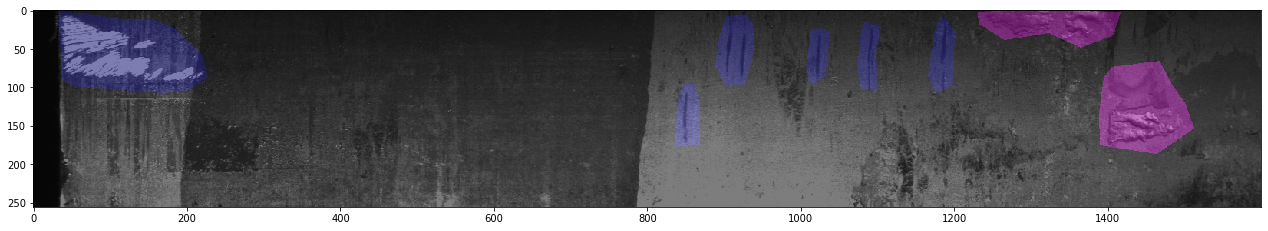

In [12]:
def show_image(axis, filename, df, colours):
    row_ids = np.where(df["image_id"] == filename)[0]
    if not row_ids.size:
        raise ValueError(f"Cannot find image {filename}")
        
    assert len(row_ids) <= len(colours)
    
    
    combined_image = None
    for i, (row_id, colour) in enumerate(zip(row_ids, colours)):
        row = df.iloc[row_id]
        
        filename = os.path.join("/", "workspace", "data", "train", row.image_id)
        assert os.path.isfile(filename)

        data = cv2.imread(filename)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        if i == 0:
            combined_image = data

        if not isinstance(row.encoded_pixels, str):
            continue    

        width, height, _ = data.shape
        
        mask = compute_mask(row, (width, height))
        
        full_mask = np.array([
            mask * colour[0],
            mask * colour[1],
            mask * colour[2],
        ])
        mask = np.transpose(full_mask, [1, 2, 0]).astype(np.uint8)
        
        combined_image = cv2.addWeighted(mask, 0.3, combined_image, 0.7, 0)
    
    axis.imshow(combined_image)
    
test_filename = with_pixels.iloc[5].image_id
colours = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 0.0, 1.0)]

fig, axis = plt.subplots(figsize=(22, 8))
show_image(axis, test_filename, df, colours)

## Mask R-CNN model

Now we construct the model based on the mrcnn package.

In [13]:
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

In [14]:
class MyConfig(Config):
    BACKBONE = "resnet50"
    NAME = "steel"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 4
    STEPS_PER_EPOCH = 250
    VALIDATION_STEPS = 10
    
config = MyConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [15]:
class MyDataset(Dataset):
    
    SHAPE = (1600, 256)
    
    def load_from(self, df):
        self.df = df
        
        self.add_class("", 1, "class 1")
        self.add_class("", 2, "class 2")       
        self.add_class("", 3, "class 3")
        self.add_class("", 4, "class 4")
        
        for image_id, g in df.groupby("image_id"):
            filename = os.path.join("/", "workspace", "data", "train", image_id)
            assert os.path.isfile(filename)
            self.add_image("", image_id, filename)
            
    def load_mask(self, image_idx):
        width, height = self.SHAPE
        
        image_id = self.image_info[image_idx]["id"]
        
        selection = self.df.query("image_id == @image_id") 
        assert len(selection)
    
        total_mask = np.zeros((height, width, 4))
        class_ids = []
        for i, (_, row) in enumerate(selection.iterrows()):
            if not isinstance(row.encoded_pixels, str):
                continue

            class_ids.append(int(row.class_id))

            mask = np.zeros(width * height, dtype=np.uint8)
            pixels = np.array(list(map(int, row.encoded_pixels.split())))
            mask_start = pixels[0::2]
            mask_length = pixels[1::2]

            for s, l in zip(mask_start, mask_length):
                mask[s:s + l] = 255

            mask = np.flipud(np.rot90(mask.reshape((width, height))))
            total_mask[:, :, i] = mask
            
        return total_mask, np.array([1, 2, 3, 4])

In [16]:
dataset_train = MyDataset()
dataset_train.load_from(df[df.train == True])
dataset_train.prepare()

dataset_val = MyDataset()
dataset_val.load_from(df[df.train == False])
dataset_val.prepare()

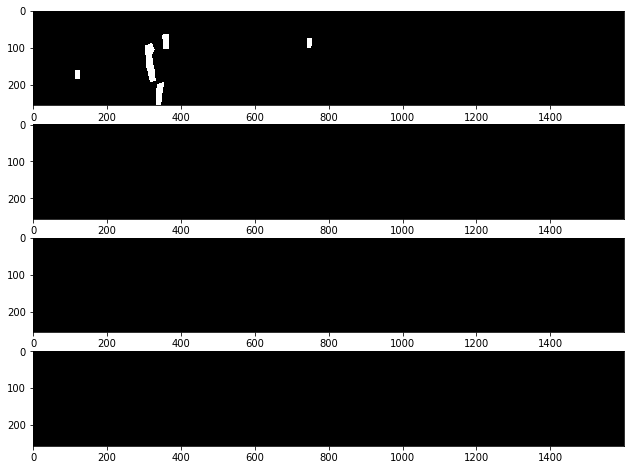

In [18]:
def investigate_mask(idx):
    mask, class_ids = dataset_train.load_mask(idx)
    if not mask.any():
        print("No regions found")
        return
    
    fig, axes = plt.subplots(len(class_ids), 1, figsize=(22, 8))
    try:
        axes = axes.ravel()
    except AttributeError:
        axes = [axes]
    for i, (c, ax) in enumerate(zip(class_ids, axes)):
        m = mask[:, :, i]
        ax.imshow(m, cmap="gray")
        
    
investigate_mask(0)

In [21]:
# Load the model
model = MaskRCNN(mode="training", config=config, model_dir="modeldir")
model.load_weights("/mask-rcnn-src/maks_rcnn_coco.h5", by_name=True, exclude=["mrcnn_bbox_fc", "mrcnn_class_logits", "mrcnn_mask", "mrcnn_bbox"])

# Training

In [ ]:
%time model.train(dataset_train, dataset_val, epochs=40, layers="heads", learning_rate=config.LEARNING_RATE)